<a href="https://colab.research.google.com/github/zjc664656505/BQ_PROJECT/blob/main/REI_feature%2Bmodel%2Beval%2Bvisual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import

In [1]:
#Mount to your google drive
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [2]:
!pip install pytorch-forecasting

     |████████████████████████████████| 112kB 8.2MB/s 
     |████████████████████████████████| 808kB 35.6MB/s 
     |████████████████████████████████| 22.3MB 62.0MB/s 
     |████████████████████████████████| 307kB 51.1MB/s 
     |████████████████████████████████| 122kB 49.6MB/s 
     |████████████████████████████████| 829kB 41.7MB/s 
     |████████████████████████████████| 645kB 37.4MB/s 
     |████████████████████████████████| 10.6MB 41.7MB/s 
     |████████████████████████████████| 276kB 50.9MB/s 
     |████████████████████████████████| 174kB 54.7MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 1.3MB 34.8MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 112kB 51.3MB/s 
     |████████████████████████████████| 143kB 53.0MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 143kB 47.6MB/s 
     |████████████████████████████████| 296kB 55.4MB

In [3]:
#import important packages
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import NaNLabelEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [6]:
data = pd.read_csv("/content/drive/MyDrive/BrightQuery_Project/Report_Sample_Data/data_3000.csv") #fail to run if relative path

data = data.drop([data.columns[0]], axis = 1)


In [7]:
def feature_selection(dataframe, feature_list):
  '''
    This is a method which returns the new dataframe in which the features are selected
  '''
  return dataframe[feature_list]

In [8]:
company_info= ['bq_sector_name', 'bq_business_code', 'bq_id', 'bq_company_address1_state','bq_public_indicator']

company_variables_ts = ['bq_id', 'bq_year']

#Credit risk indicators list
credit_ind_list = ['bq_terminate_any_ind', 'bq_final_filing_any_ind','bq_fail_trans_contrib_pens_ind', 
                 'bq_fail_trans_contrib_welf_ind', 'bq_fail_provide_benf_due_pens_ind', 'bq_fail_provide_benf_due_welf_ind', 
                  'bq_vol_delinquent_filer_pgrm_ind', 'bq_amended_ind','bq_profit_plan_no_co_contribs_ind', 
                  'bq_no_co_contribs_ind', 'bq_no_tot_contribs_ind', 'bq_pens_negative_contrib_ind',	
                  'bq_terminate_pens_ind', 'bq_final_filing_pens_ind',	'bq_no_profit_sharing_ind',
                  'bq_fail_trans_contrib_any_ind', 'bq_fail_provide_benf_due_any_ind']

# Welfare score indicators list
welfare_ind_list = ['bq_health_insurance_ind', 'bq_dental_insurance_ind', 'bq_vision_insurance_ind', 
                  'bq_life_insurance_ind', 'bq_long_term_dis_insurance_ind', 'bq_temp_disability_insurance_ind', 
                  'bq_supp_unemploy_ins_ind', 'bq_death_benefits_ind', 'bq_prepaid_legal_ind', 
                  'bq_scholarship_funded_ind', 'bq_severance_pay_ind', 'bq_apprentice_and_training_ind',
                  'bq_welf_only_ind','bq_welf_ez_only_ind']

# Retirement score indicators list
retirement_ind_list = ['bq_defined_contrib_pens_ind', 'bq_defined_benefit_pens_ind', 'bq_profit_sharing_ind', 
                  'bq_code_section_401k_ind', 'bq_stock_bonus_ind', 'bq_comp_contribute_pens_ind',
                  'bq_target_benefit_plan_ind', 'bq_money_purchase_plan_ind', 'bq_plan_ins_fdlty_bond_ind',
                   'bq_pens_only_ind', 'bq_ez_only_ind']

# Employment & payroll indicators list
payroll_ind_list = ['bq_growth_tot_contrib_per_emp_curr_a_1yr_ind', 'bq_growth_tot_contrib_pens_amt_a_1yr_ind',
                        'bq_growth_co_contrib_pens_amt_a_1yr_ind', 'bq_growth_co_contrib_per_emp_curr_a_1yr_ind',
                        'bq_growth_emp_contrib_pens_amt_a_1yr_ind', 'bq_growth_emp_contrib_per_emp_curr_a_1yr_ind',
                        'bq_growth_revenue_1yr_ind', 'bq_growth_ebitda_1yr_ind', 'bq_growth_cor_1yr_ind',
                        'bq_growth_net_income_1yr_ind', 'bq_growth_gross_profit_1yr_ind', 'bq_growth_total_assets_1yr_ind',
                        'bq_growth_operating_expenses_1yr_ind', 'bq_growth_operating_income_1yr_ind', 
                        'bq_growth_tax_and_interest_1yr_ind', 'bq_growth_revenue_per_emp_1yr_ind',
                        'bq_growth_ebitda_per_emp_1yr_ind', 'bq_growth_cor_per_emp_1yr_ind',
                        'bq_growth_net_income_per_emp_1yr_ind', 'bq_growth_gross_profit_per_emp_1yr_ind',
                        'bq_growth_total_assets_per_emp_1yr_ind', 'bq_growth_operating_expenses_per_emp_1yr_ind',
                        'bq_growth_operating_income_per_emp_1yr_ind', 'bq_growth_tax_and_interest_per_emp_1yr_ind',
                        'bq_growth_savings_score_1yr_ind', 'bq_growth_welfare_score_1yr_ind', 
                        'bq_growth_retirement_score_1yr_ind', 'bq_growth_credit_score_1yr_ind',
                        'bq_growth_benefits_score_1yr_ind', 'bq_growth_smb_default_score_1yr_ind']

# Financial feature list
financials_feature_list = ['bq_revenue', 'bq_ebitda', 'bq_cor', 'bq_net_income', 
                           'bq_gross_profit', 'bq_total_assets','bq_operating_expenses',
                           'bq_operating_income', 'bq_tax_and_interest',
                           'bq_gross_profit_margin', 'bq_ebitda_margin', 'bq_asset_turnover',
                           'bq_net_profit_margin', 'bq_return_on_assets', 'bq_return_on_sales',
                           'bq_revenue_per_emp', 'bq_ebitda_per_emp', 'bq_cor_per_emp',
                           'bq_net_income_per_emp', 'bq_gross_profit_per_emp', 'bq_total_assets_per_emp',
                           'bq_operating_expenses_per_emp', 'bq_operating_income_per_emp', 
                           'bq_tax_and_interest_per_emp']

In [9]:
#feature selection methods

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectKBest, mutual_info_regression

def ridge_selector(X, y, n):
  ridge = Ridge().fit(X,y)
  embeded_lr_selector = SelectFromModel(ridge, max_features=n).fit(X, y)
  embeded_lr_selector_support = embeded_lr_selector.get_support()
  return embeded_lr_selector_support

def lasso_selector(X, y, n):
  lasso = Lasso(alpha=0.5, max_iter=75000, tol = 0.032).fit(X, y)
  embeded_lr_selector = SelectFromModel(lasso, max_features=n).fit(X, y)
  embeded_lr_selector_support = embeded_lr_selector.get_support()
  return embeded_lr_selector_support

def rf_selector(X, y, n):
  rf = DecisionTreeRegressor(random_state=1)
  embeded_rf_selector = SelectFromModel(rf, max_features=n).fit(X, y)
  embeded_rf_selector_support = embeded_rf_selector.get_support()
  return embeded_rf_selector_support

def RFE_selector(X, y, n):
  rfe_selector = RFE(estimator=DecisionTreeRegressor(random_state=1), n_features_to_select=n, step=5, verbose=5)
  rfe_selector.fit(X, y)
  rfe_support = rfe_selector.get_support()
  return rfe_support

def svr_selector(X, y, n):
  selector = SelectFromModel(estimator=LinearSVR(), max_features=n).fit(X, y)
  svr_selector_support = selector.get_support()
  return svr_selector_support

def mutual_information_selector(X, y, n):
  '''
    This is a method which returns the new dataframe of the n top features to select on mutual_info_regression score
  '''
  mir_selector = SelectKBest(mutual_info_regression, k=n)
  mir_selector.fit(X, y)
  mir_support = mir_selector.get_support()
  return mir_support

In [10]:
def feature_select_tb(x, y, n, ridge = False, lasso = False):
  feature_col = [i for i in x.columns]
  if ridge:
    ridge_idx = []
    ridge_counter = 0
    for i in ridge_selector(x, y, n):
      if i == True:
        ridge_idx.append(ridge_counter)
      ridge_counter += 1
    ridge_feature = [feature_col[i] for i in ridge_idx]
  
  if lasso:
    lasso_idx = []
    lasso_counter = 0
    for i in lasso_selector(x, y, n):
      if i == True:
        lasso_idx.append(lasso_counter)
      lasso_counter += 1
    lasso_feature = [feature_col[i] for i in lasso_idx]
  
  RFE_idx = []
  RFE_counter = 0
  for i in RFE_selector(x, y, n):
    if i == True:
      RFE_idx.append(RFE_counter)
    RFE_counter += 1
  RFE_feature = [feature_col[i] for i in RFE_idx]

  # svr_idx = []
  # svr_counter = 0
  # for i in svr_selector(x, y, n):
  #   if i == True:
  #     svr_idx.append(svr_counter)
  #   svr_counter += 1
  # svr_feature = [feature_col[i] for i in svr_idx]

  mi_idx = []
  mi_counter = 0
  for i in mutual_information_selector(x, y, n):
    if i == True:
      mi_idx.append(mi_counter)
    mi_counter += 1
  mi_feature = [feature_col[i] for i in mi_idx]

  if ridge:
    ridge_final = []
    ridge_final.extend(ridge_feature)
    ridge_final.extend(RFE_feature)
    ridge_final.extend(svr_feature)
    ridge_final.extend(mi_feature)
    print("ridge:", ridge_feature)
    print("rfe:", RFE_feature)
    # print("svr:", svr_feature)
    print("mi:", mi_feature)
    return set(ridge_final)

  if lasso:
    lasso_final = []
    lasso_final.extend(lasso_feature)
    lasso_final.extend(RFE_feature)
    # lasso_final.extend(svr_feature)
    lasso_final.extend(mi_feature)
    print("lasso:", lasso_feature)
    print("rfe:", RFE_feature)
    # print("svr:", svr_feature)
    print("mi:", mi_feature)
    return set(lasso_final)

In [11]:
indicators = credit_ind_list+welfare_ind_list+retirement_ind_list+payroll_ind_list

In [12]:
def feature_category(feature):
  f_len = len(feature)
  category = []
  for i in range(f_len):
    if feature[i] in credit_ind_list:
      category.append("Credit Risk")
    elif feature[i] in welfare_ind_list:
      category.append("Welfare")
    elif feature[i] in retirement_ind_list:
      category.append("Retirement")
    elif feature[i] in payroll_ind_list:
      category.append("Employment & payroll")
    elif feature[i] in financials_feature_list:
      category.append("Financials")
    else:
      category.append("Statistics")
  return category

In [13]:
from itertools import chain
import matplotlib.pyplot as plt

### Revenue Feature Selection, Model Training, Evaluation

In [14]:
y_revenue = data["bq_revenue"]
X_revenue = data.copy()
X_revenue.drop(["bq_revenue", "bq_id", "bq_year", 'bq_sector_name', 'bq_business_code', 'bq_company_address1_state'], inplace = True, axis = 1)

In [15]:
X_revenue = feature_selection(X_revenue, indicators)
revenue_ridge = ridge_selector(X_revenue, y_revenue, 20)
revenue_RFE = RFE_selector(X_revenue, y_revenue, 20)
revenue_rf = rf_selector(X_revenue, y_revenue, 20)
revenue_MI = mutual_information_selector(X_revenue, y_revenue, 20)
revenue_feature_category = feature_category(X_revenue.columns)

# put all selection together for revenue
feature_selection_revenue = pd.DataFrame({'Revenue Features':X_revenue.columns,  'Category':revenue_feature_category, 'Ridge': revenue_ridge,
                                         'RFE':revenue_RFE, 
                                         'Mutual Info':revenue_MI, 'RF': revenue_rf})
# count the selected times for each feature
feature_selection_revenue['Total'] = np.sum(feature_selection_revenue, axis=1)
revenue_selection_indicators = feature_selection_revenue.nlargest(60,'Total')

Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 57 features.
Fitting estimator with 52 features.
Fitting estimator with 47 features.
Fitting estimator with 42 features.
Fitting estimator with 37 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.


In [16]:
#feature ranking

revenue_selection_indicators

,Revenue Features,Category,Ridge,RFE,Mutual Info,RF,Total
16,bq_fail_provide_benf_due_any_ind,Credit Risk,True,True,True,True,4
19,bq_vision_insurance_ind,Welfare,True,True,True,True,4
23,bq_supp_unemploy_ins_ind,Welfare,True,True,True,True,4
25,bq_prepaid_legal_ind,Welfare,True,True,True,True,4
27,bq_severance_pay_ind,Welfare,True,True,True,True,4
32,bq_defined_benefit_pens_ind,Retirement,True,True,True,True,4
35,bq_stock_bonus_ind,Retirement,True,True,True,True,4
0,bq_terminate_any_ind,Credit Risk,True,True,False,True,3
1,bq_final_filing_any_ind,Credit Risk,True,True,False,True,3
22,bq_temp_disability_insurance_ind,Welfare,False,True,True,True,3


In [17]:
#feature select top 20

revenue_indicators = revenue_selection_indicators[:20]['Revenue Features']
categorical_revenue_feature = revenue_indicators
categorical_revenue_feature

16     bq_fail_provide_benf_due_any_ind
19              bq_vision_insurance_ind
23             bq_supp_unemploy_ins_ind
25                 bq_prepaid_legal_ind
27                 bq_severance_pay_ind
32          bq_defined_benefit_pens_ind
35                   bq_stock_bonus_ind
0                  bq_terminate_any_ind
1               bq_final_filing_any_ind
22     bq_temp_disability_insurance_ind
24                bq_death_benefits_ind
26            bq_scholarship_funded_ind
38           bq_money_purchase_plan_ind
2        bq_fail_trans_contrib_pens_ind
4     bq_fail_provide_benf_due_pens_ind
7                        bq_amended_ind
13             bq_final_filing_pens_ind
14             bq_no_profit_sharing_ind
21       bq_long_term_dis_insurance_ind
28       bq_apprentice_and_training_ind
Name: Revenue Features, dtype: object

In [18]:
#data transform

max_prediction_length = 1 # maximum output size of the decoder: set to 1. We want to predict future 1 year's data.
max_encoder_length = 5 # maximum output size of the encoder: set to 4. Past number of year training data.

def data_transformation(input_df, indicator):
  df = input_df
  df["bq_id"] = df.bq_id.astype(str)
  df[indicator] = (df[indicator].apply(lambda x: x.map({0: "-", 1: x.name}).astype("category")))
  df["bq_year"] = df.bq_year.astype(str).astype("category")
  df["bq_business_code"] = df.bq_business_code.astype(str).astype("category")
  return df

meta_data_copy3 = data.copy()
meta_data_copy3["time_idx"] = meta_data_copy3["bq_year"] * 1 #Multiply by 3 because the seasonality of the company is 3.
meta_data_copy3["time_idx"] -= meta_data_copy3["time_idx"].min()
meta_data_copy3 = data_transformation(meta_data_copy3, categorical_revenue_feature)
meta_data_copy3 = meta_data_copy3[meta_data_copy3.groupby(['bq_id', 'bq_sector_name', 'bq_business_code', 'bq_company_address1_state']).bq_id.transform(len) > 1]

In [19]:
#data for train
training_cutoff = meta_data_copy3["time_idx"].max() - max_prediction_length
training = TimeSeriesDataSet(
    meta_data_copy3[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="bq_revenue",
    group_ids=["bq_id", "bq_sector_name", "bq_business_code", "bq_company_address1_state"], #bq_business_code, bq_sector_name/bq_sector_code
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["bq_id", "bq_sector_name", "bq_business_code", "bq_company_address1_state"],
    static_reals=[],
    time_varying_known_categoricals=["indicator"],
    variable_groups={"indicator": categorical_revenue_feature},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'bq_revenue'
    ],
    target_normalizer=GroupNormalizer(
        groups=["bq_id", "bq_sector_name", "bq_business_code", "bq_company_address1_state"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning:

Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 18 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__bq_id': '110321714', '__group_id__bq_sector_name': 'Health Care and Social Assistance', '__group_id__bq_business_code': '621510', '__group_id__bq_company_address1_state': 'CA'}, {'__group_id__bq_id': '113132815', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_code': '339110', '__group_id__bq_company_address1_state': 'MA'}, {'__group_id__bq_id': '125119035', '__group_id__bq_sector_name': 'Retail Trade', '__group_id__bq_business_code': '451110', '__group_id__bq_company_address1_state': 'TX'}, {'__group_id__bq_id': '129654498', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_cod

In [20]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, meta_data_copy3, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning:

Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 12 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__bq_id': '110321714', '__group_id__bq_sector_name': 'Health Care and Social Assistance', '__group_id__bq_business_code': '621510', '__group_id__bq_company_address1_state': 'CA'}, {'__group_id__bq_id': '113132815', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_code': '339110', '__group_id__bq_company_address1_state': 'MA'}, {'__group_id__bq_id': '125119035', '__group_id__bq_sector_name': 'Retail Trade', '__group_id__bq_business_code': '451110', '__group_id__bq_company_address1_state': 'TX'}, {'__group_id__bq_id': '129654498', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_cod

In [21]:
# configure network and trainer
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=35, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=40, #I set the max_epoch to 200, but you are free to set it to any number, please remember it takes very long time to train
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate= 5e-2,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 31.9k


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.



In [22]:
# fit network
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 11.9 K
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 2.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9

Global seed set to 42


/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



In [23]:
from sklearn.metrics import r2_score
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# # calcualte mean absolute error on validation set
revenue_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
revenue_predictions = best_tft.predict(val_dataloader)

revenue_predictions = torch.nan_to_num(revenue_predictions)
r2_score(revenue_actuals, revenue_predictions)

0.9609053275306464

In [24]:
def RAE(actual_tensor, prediction_tensor):
  actual = torch.tensor([i[0] for i in actual_tensor])
  prediction = torch.tensor([i[0] for i in prediction_tensor])
  average = torch.mean(actual)
  above = []
  below = []

  for i in (actual-prediction).abs():
    if np.isnan(i):
      above.append(0)
    else:
      above.append(float(i))

  for i in actual:
    term = abs(i-average)
    if np.isnan(term):
      below.append(0)
    else:
      below.append(float(term))
  return sum(above) / sum(below)

RAE(revenue_actuals, revenue_predictions)

0.11091238157606775

### Ebitda Feature Selection, Model Training, Evaluation

In [25]:
y_ebitda = data["bq_ebitda"]
X_ebitda = data.copy()
X_ebitda.drop(["bq_ebitda", "bq_id", "bq_year", 'bq_sector_name', 'bq_business_code', 'bq_company_address1_state'], inplace = True, axis = 1)

In [26]:
X_ebitda = feature_selection(X_ebitda, indicators)
ebitda_ridge = ridge_selector(X_ebitda, y_ebitda, 20)
ebitda_RFE = RFE_selector(X_ebitda, y_ebitda, 20)
ebitda_rf = rf_selector(X_ebitda, y_ebitda, 20)
ebitda_MI = mutual_information_selector(X_ebitda, y_ebitda, 20)
ebitda_feature_category = feature_category(X_ebitda.columns)

# put all selection together for ebitda
feature_selection_ebitda = pd.DataFrame({'Ebitda Features':X_ebitda.columns,  'Category':ebitda_feature_category, 'Ridge': ebitda_ridge,
                                         'RFE':ebitda_RFE, 
                                         'Mutual Info':ebitda_MI, 'RF': ebitda_rf})
# count the selected times for each feature
feature_selection_ebitda['Total'] = np.sum(feature_selection_ebitda, axis=1)
ebitda_selection_indicators = feature_selection_ebitda.nlargest(60,'Total')

Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 57 features.
Fitting estimator with 52 features.
Fitting estimator with 47 features.
Fitting estimator with 42 features.
Fitting estimator with 37 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.


In [27]:
#feature ranking

ebitda_selection_indicators

,Ebitda Features,Category,Ridge,RFE,Mutual Info,RF,Total
19,bq_vision_insurance_ind,Welfare,True,True,True,True,4
23,bq_supp_unemploy_ins_ind,Welfare,True,True,True,True,4
25,bq_prepaid_legal_ind,Welfare,True,True,True,True,4
27,bq_severance_pay_ind,Welfare,True,True,True,True,4
32,bq_defined_benefit_pens_ind,Retirement,True,True,True,True,4
1,bq_final_filing_any_ind,Credit Risk,True,True,False,True,3
16,bq_fail_provide_benf_due_any_ind,Credit Risk,True,True,False,True,3
21,bq_long_term_dis_insurance_ind,Welfare,False,True,True,True,3
22,bq_temp_disability_insurance_ind,Welfare,False,True,True,True,3
24,bq_death_benefits_ind,Welfare,False,True,True,True,3


In [28]:
#feature select top 20

ebitda_indicators = ebitda_selection_indicators[:20]['Ebitda Features']
categorical_ebitda_feature = ebitda_indicators
categorical_ebitda_feature

19             bq_vision_insurance_ind
23            bq_supp_unemploy_ins_ind
25                bq_prepaid_legal_ind
27                bq_severance_pay_ind
32         bq_defined_benefit_pens_ind
1              bq_final_filing_any_ind
16    bq_fail_provide_benf_due_any_ind
21      bq_long_term_dis_insurance_ind
22    bq_temp_disability_insurance_ind
24               bq_death_benefits_ind
35                  bq_stock_bonus_ind
38          bq_money_purchase_plan_ind
0                 bq_terminate_any_ind
7                       bq_amended_ind
12               bq_terminate_pens_ind
13            bq_final_filing_pens_ind
15       bq_fail_trans_contrib_any_ind
17             bq_health_insurance_ind
26           bq_scholarship_funded_ind
34            bq_code_section_401k_ind
Name: Ebitda Features, dtype: object

In [29]:
#data transform

max_prediction_length = 1 # maximum output size of the decoder: set to 1. We want to predict future 1 year's data.
max_encoder_length = 5 # maximum output size of the encoder: set to 4. Past number of year training data.

def data_transformation(input_df, indicator):
  df = input_df
  df["bq_id"] = df.bq_id.astype(str)
  df[indicator] = (df[indicator].apply(lambda x: x.map({0: "-", 1: x.name}).astype("category")))
  df["bq_year"] = df.bq_year.astype(str).astype("category")
  df["bq_business_code"] = df.bq_business_code.astype(str).astype("category")
  return df

meta_data_copy3 = data.copy()
meta_data_copy3["time_idx"] = meta_data_copy3["bq_year"] * 1 #Multiply by 3 because the seasonality of the company is 3.
meta_data_copy3["time_idx"] -= meta_data_copy3["time_idx"].min()
meta_data_copy3 = data_transformation(meta_data_copy3, categorical_ebitda_feature)
meta_data_copy3 = meta_data_copy3[meta_data_copy3.groupby(['bq_id', 'bq_sector_name', 'bq_business_code', 'bq_company_address1_state']).bq_id.transform(len) > 1]

In [30]:
#data train

training_cutoff = meta_data_copy3["time_idx"].max() - max_prediction_length
training = TimeSeriesDataSet(
    meta_data_copy3[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="bq_ebitda",
    group_ids=["bq_id", "bq_sector_name", "bq_business_code", "bq_company_address1_state"], #bq_business_code, bq_sector_name/bq_sector_code
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["bq_id", "bq_sector_name", "bq_business_code", "bq_company_address1_state"],
    static_reals=[],
    time_varying_known_categoricals=["indicator"],
    variable_groups={"indicator": categorical_ebitda_feature},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'bq_ebitda'
    ],
    target_normalizer=GroupNormalizer(
        groups=["bq_id", "bq_sector_name", "bq_business_code", "bq_company_address1_state"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning:

Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 18 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__bq_id': '110321714', '__group_id__bq_sector_name': 'Health Care and Social Assistance', '__group_id__bq_business_code': '621510', '__group_id__bq_company_address1_state': 'CA'}, {'__group_id__bq_id': '113132815', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_code': '339110', '__group_id__bq_company_address1_state': 'MA'}, {'__group_id__bq_id': '125119035', '__group_id__bq_sector_name': 'Retail Trade', '__group_id__bq_business_code': '451110', '__group_id__bq_company_address1_state': 'TX'}, {'__group_id__bq_id': '129654498', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_cod

In [31]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, meta_data_copy3, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning:

Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 12 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__bq_id': '110321714', '__group_id__bq_sector_name': 'Health Care and Social Assistance', '__group_id__bq_business_code': '621510', '__group_id__bq_company_address1_state': 'CA'}, {'__group_id__bq_id': '113132815', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_code': '339110', '__group_id__bq_company_address1_state': 'MA'}, {'__group_id__bq_id': '125119035', '__group_id__bq_sector_name': 'Retail Trade', '__group_id__bq_business_code': '451110', '__group_id__bq_company_address1_state': 'TX'}, {'__group_id__bq_id': '129654498', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_cod

In [32]:
# configure network and trainer
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=35, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=40, #I set the max_epoch to 200, but you are free to set it to any number, please remember it takes very long time to train
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate= 5e-2,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 31.9k


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.



In [33]:
# fit network
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 11.9 K
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 2.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9

Global seed set to 42


/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



In [34]:
from sklearn.metrics import r2_score
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# # calcualte mean absolute error on validation set
ebitda_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
ebitda_predictions = best_tft.predict(val_dataloader)

ebitda_predictions = torch.nan_to_num(ebitda_predictions)
r2_score(ebitda_actuals, ebitda_predictions)

0.8800106625769353

In [35]:
RAE(ebitda_actuals, ebitda_predictions)

0.2645189512247934

### Net Income Feature Selection, Model Training, Evaluation

In [36]:
y_net_income = data["bq_net_income"]
X_net_income = data.copy()
X_net_income.drop(["bq_net_income", "bq_id", "bq_year", 'bq_sector_name', 'bq_business_code', 'bq_company_address1_state'], inplace = True, axis = 1)

In [37]:
X_net_income = feature_selection(X_net_income, indicators)
net_income_ridge = ridge_selector(X_net_income, y_net_income, 20)
net_income_RFE = RFE_selector(X_net_income, y_net_income, 20)
net_income_rf = rf_selector(X_net_income, y_net_income, 20)
net_income_MI = mutual_information_selector(X_net_income, y_net_income, 20)
net_income_feature_category = feature_category(X_net_income.columns)

# put all selection together for revenue
feature_selection_net_income = pd.DataFrame({'Net Income Features':X_net_income.columns,  'Category':net_income_feature_category, 'Ridge': net_income_ridge,
                                         'RFE':net_income_RFE, 
                                         'Mutual Info':net_income_MI, 'RF': net_income_rf})
# count the selected times for each feature
feature_selection_net_income['Total'] = np.sum(feature_selection_net_income, axis=1)
net_income_selection_indicators = feature_selection_net_income.nlargest(60,'Total')

Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 57 features.
Fitting estimator with 52 features.
Fitting estimator with 47 features.
Fitting estimator with 42 features.
Fitting estimator with 37 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.


In [38]:
#feature ranking

net_income_selection_indicators

,Net Income Features,Category,Ridge,RFE,Mutual Info,RF,Total
19,bq_vision_insurance_ind,Welfare,True,True,True,True,4
25,bq_prepaid_legal_ind,Welfare,True,True,True,True,4
27,bq_severance_pay_ind,Welfare,True,True,True,True,4
32,bq_defined_benefit_pens_ind,Retirement,True,True,True,True,4
35,bq_stock_bonus_ind,Retirement,True,True,True,True,4
1,bq_final_filing_any_ind,Credit Risk,False,True,True,True,3
4,bq_fail_provide_benf_due_pens_ind,Credit Risk,True,True,False,True,3
7,bq_amended_ind,Credit Risk,False,True,True,True,3
17,bq_health_insurance_ind,Welfare,True,True,True,False,3
21,bq_long_term_dis_insurance_ind,Welfare,False,True,True,True,3


In [39]:
#select top 20 features

net_income_indicators = net_income_selection_indicators[:20]['Net Income Features']
categorical_net_income_feature = net_income_indicators
categorical_net_income_feature

19              bq_vision_insurance_ind
25                 bq_prepaid_legal_ind
27                 bq_severance_pay_ind
32          bq_defined_benefit_pens_ind
35                   bq_stock_bonus_ind
1               bq_final_filing_any_ind
4     bq_fail_provide_benf_due_pens_ind
7                        bq_amended_ind
17              bq_health_insurance_ind
21       bq_long_term_dis_insurance_ind
22     bq_temp_disability_insurance_ind
23             bq_supp_unemploy_ins_ind
24                bq_death_benefits_ind
38           bq_money_purchase_plan_ind
12                bq_terminate_pens_ind
13             bq_final_filing_pens_ind
15        bq_fail_trans_contrib_any_ind
26            bq_scholarship_funded_ind
28       bq_apprentice_and_training_ind
33                bq_profit_sharing_ind
Name: Net Income Features, dtype: object

In [40]:
#data transform

max_prediction_length = 1 # maximum output size of the decoder: set to 1. We want to predict future 1 year's data.
max_encoder_length = 5 # maximum output size of the encoder: set to 4. Past number of year training data.

def data_transformation(input_df, indicator):
  df = input_df
  df["bq_id"] = df.bq_id.astype(str)
  df[indicator] = (df[indicator].apply(lambda x: x.map({0: "-", 1: x.name}).astype("category")))
  df["bq_year"] = df.bq_year.astype(str).astype("category")
  df["bq_business_code"] = df.bq_business_code.astype(str).astype("category")
  return df

meta_data_copy3 = data.copy()
meta_data_copy3["time_idx"] = meta_data_copy3["bq_year"] * 1 #Multiply by 3 because the seasonality of the company is 3.
meta_data_copy3["time_idx"] -= meta_data_copy3["time_idx"].min()
meta_data_copy3 = data_transformation(meta_data_copy3, categorical_net_income_feature)
meta_data_copy3 = meta_data_copy3[meta_data_copy3.groupby(['bq_id', 'bq_sector_name', 'bq_business_code', 'bq_company_address1_state']).bq_id.transform(len) > 1]

In [41]:
#data train

training_cutoff = meta_data_copy3["time_idx"].max() - max_prediction_length
training = TimeSeriesDataSet(
    meta_data_copy3[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="bq_net_income",
    group_ids=["bq_id", "bq_sector_name", "bq_business_code", "bq_company_address1_state"], #bq_business_code, bq_sector_name/bq_sector_code
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["bq_id", "bq_sector_name", "bq_business_code", "bq_company_address1_state"],
    static_reals=[],
    time_varying_known_categoricals=["indicator"],
    variable_groups={"indicator": categorical_net_income_feature},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'bq_net_income'
    ],
    target_normalizer=GroupNormalizer(
        groups=["bq_id", "bq_sector_name", "bq_business_code", "bq_company_address1_state"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning:

Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 18 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__bq_id': '110321714', '__group_id__bq_sector_name': 'Health Care and Social Assistance', '__group_id__bq_business_code': '621510', '__group_id__bq_company_address1_state': 'CA'}, {'__group_id__bq_id': '113132815', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_code': '339110', '__group_id__bq_company_address1_state': 'MA'}, {'__group_id__bq_id': '125119035', '__group_id__bq_sector_name': 'Retail Trade', '__group_id__bq_business_code': '451110', '__group_id__bq_company_address1_state': 'TX'}, {'__group_id__bq_id': '129654498', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_cod

In [42]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, meta_data_copy3, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning:

Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 12 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__bq_id': '110321714', '__group_id__bq_sector_name': 'Health Care and Social Assistance', '__group_id__bq_business_code': '621510', '__group_id__bq_company_address1_state': 'CA'}, {'__group_id__bq_id': '113132815', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_code': '339110', '__group_id__bq_company_address1_state': 'MA'}, {'__group_id__bq_id': '125119035', '__group_id__bq_sector_name': 'Retail Trade', '__group_id__bq_business_code': '451110', '__group_id__bq_company_address1_state': 'TX'}, {'__group_id__bq_id': '129654498', '__group_id__bq_sector_name': 'Manufacturing', '__group_id__bq_business_cod

In [43]:
# configure network and trainer
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=35, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=40, #I set the max_epoch to 200, but you are free to set it to any number, please remember it takes very long time to train
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate= 5e-2,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 31.9k


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.



In [44]:
# fit network
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 11.9 K
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 2.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9

Global seed set to 42


/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/metrics.py:555: UserWarning:

Loss is not finite. Resetting it to 1e9



In [45]:
from sklearn.metrics import r2_score
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# # calcualte mean absolute error on validation set
net_income_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
net_income_predictions = best_tft.predict(val_dataloader)

net_income_predictions = torch.nan_to_num(net_income_predictions)
r2_score(net_income_actuals, net_income_predictions)

0.6727993589140795

In [46]:
RAE(net_income_actuals, net_income_predictions)

0.45710541308231395

#Plots of Model Training Results

In [48]:
#convert from tensor object to numpy array

ebitda_actual_list = ebitda_actuals.tolist()
ebitda_actual_list = list(chain.from_iterable(ebitda_actual_list))

ebitda_prediction_list = ebitda_predictions.tolist()
ebitda_prediction_list = list(chain.from_iterable(ebitda_prediction_list))



revenue_actual_list = revenue_actuals.tolist()
revenue_actual_list = list(chain.from_iterable(revenue_actual_list))

revenue_prediction_list = revenue_predictions.tolist()
revenue_prediction_list = list(chain.from_iterable(revenue_prediction_list))



net_income_actual_list = net_income_actuals.tolist()
net_income_actual_list = list(chain.from_iterable(net_income_actual_list))

net_income_prediction_list = net_income_predictions.tolist()
net_income_prediction_list = list(chain.from_iterable(net_income_prediction_list))

###Revenue Plot

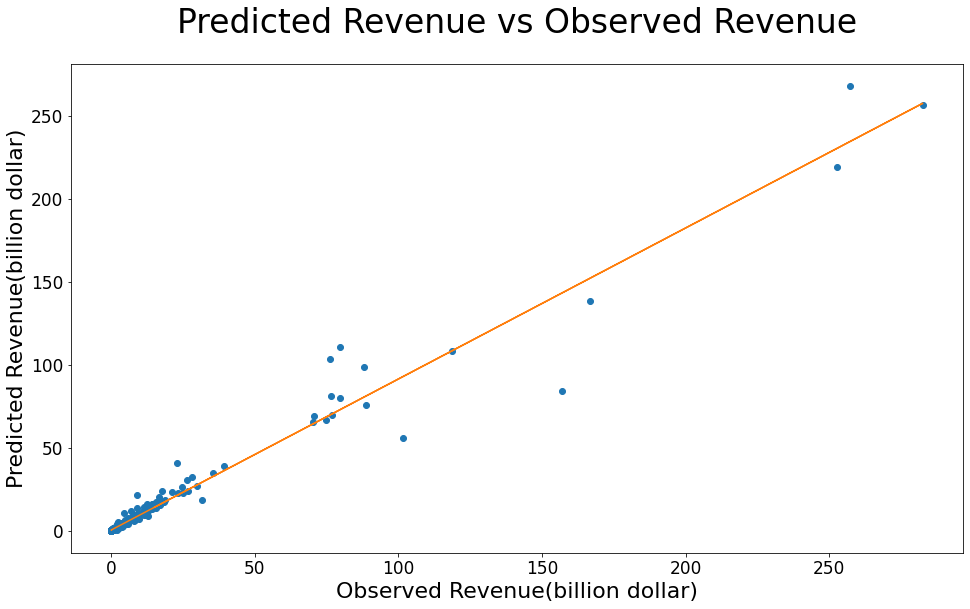

In [50]:
x = np.array(revenue_actual_list)
y = np.array(revenue_prediction_list)


#scale the unit
x = x/1000000000
y = y/1000000000

fig,ax = plt.subplots(figsize =(16, 9))


plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)


plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel("Observed Revenue(billion dollar)", fontsize=22)
plt.ylabel("Predicted Revenue(billion dollar)", fontsize=22)
plt.title("Predicted Revenue vs Observed Revenue", fontsize=33,  y=1.05)
#plt.title.set_position([.5, 1.05])
plt.show()

###Ebitda Plot

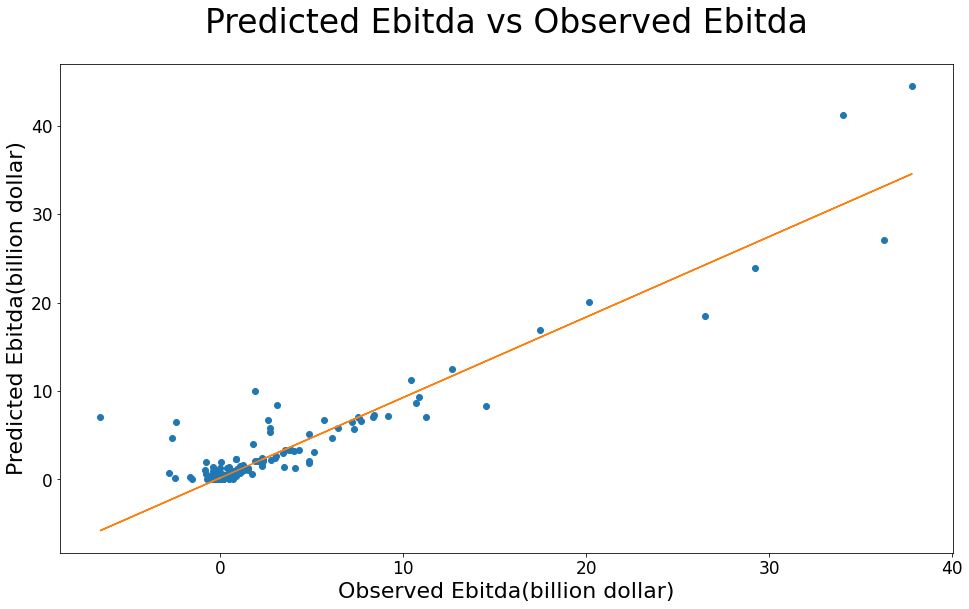

In [51]:
x = np.array(ebitda_actual_list)
y = np.array(ebitda_prediction_list)

#scale the unit
x = x/1000000000
y = y/1000000000


fig,ax = plt.subplots(figsize =(16, 9))


plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)


plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel("Observed Ebitda(billion dollar)", fontsize=22)
plt.ylabel("Predicted Ebitda(billion dollar)", fontsize=22)
plt.title("Predicted Ebitda vs Observed Ebitda", fontsize=33,  y=1.05)
#plt.title.set_position([.5, 1.05])
plt.show()

###Net Income Plot

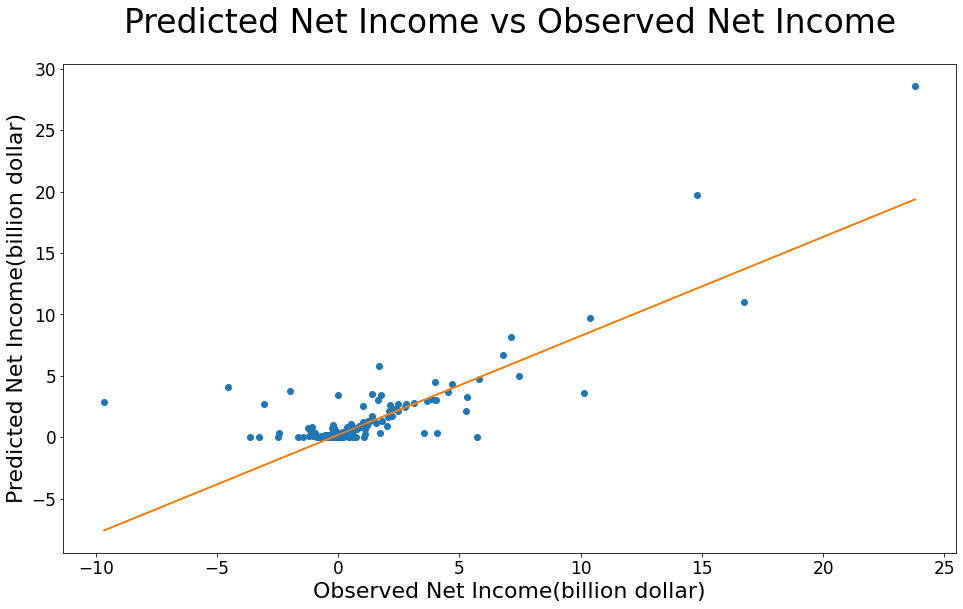

In [53]:
x = np.array(net_income_actual_list)
y = np.array(net_income_prediction_list)

#scale the unit
x = x/1000000000
y = y/1000000000

fig,ax = plt.subplots(figsize =(16, 9))


plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)


plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel("Observed Net Income(billion dollar)", fontsize=22)
plt.ylabel("Predicted Net Income(billion dollar)", fontsize=22)
plt.title("Predicted Net Income vs Observed Net Income", fontsize=33,  y=1.05)
#plt.title.set_position([.5, 1.05])
plt.show()